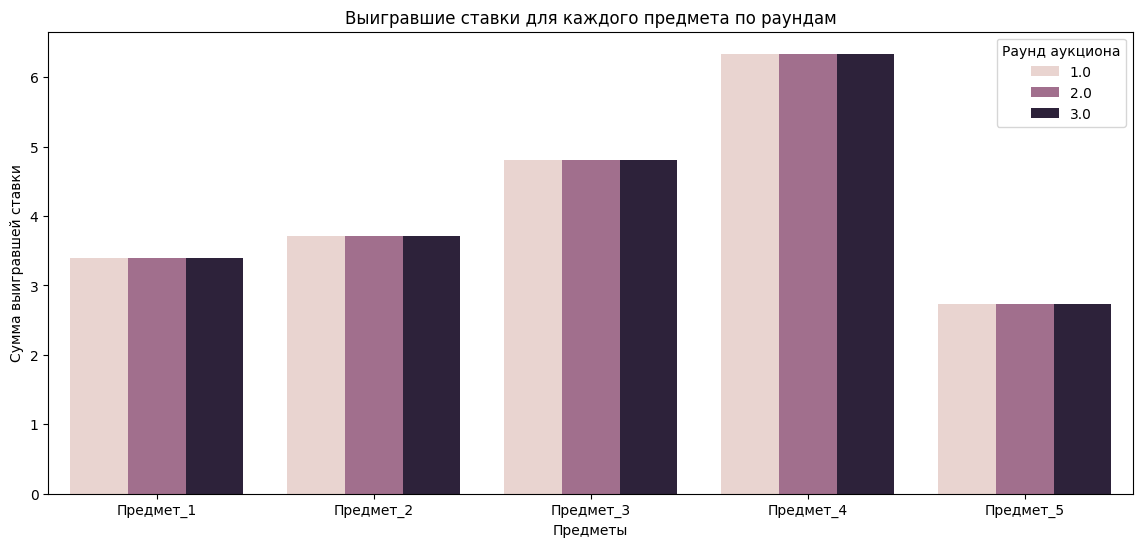

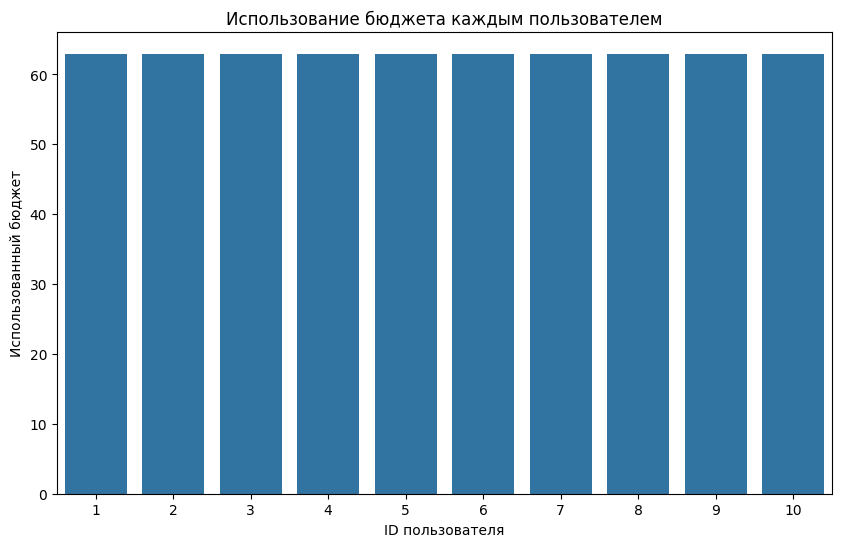

Общий доход за все раунды: 62.96324592236956
Доход по раундам: [20.987748640789853, 20.987748640789853, 20.987748640789853]


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Определяем основные параметры аукциона
num_users = 10          # Количество пользователей
num_items = 5           # Количество предметов
num_rounds = 3          # Количество раундов аукциона
user_budgets = np.random.randint(20, 50, size=num_users)  # Изначальные бюджеты пользователей
item_base_values = np.random.rand(num_items) * 10         # Базовые стоимости предметов

# Генерация предпочтений пользователей
np.random.seed(42)
user_prefs = np.random.rand(num_users, num_items)  # Матрица предпочтений пользователей к предметам

# Функция динамической корректировки ставок
def update_bid_strategy(bid, budget, remaining_rounds):
    """
    Регулирует ставки, снижая их при минимальном сокращении бюджета и при приближении к последним раундам.
    Это помогает моделировать поведение пользователей, которые осторожнее расходуют бюджет.
    """
    adjusted_bid = min(bid, budget / max(remaining_rounds, 1))  # Исключаем деление на 0
    return adjusted_bid

# Функция аукциона с динамической стратегией и ограничением бюджета
def run_auction(user_prefs, item_values, budgets, num_rounds):
    allocation_history = []  # История распределений предметов по раундам
    revenue_history = []     # История доходов по раундам

    for round_num in range(num_rounds):
        allocations = {}  # Распределения предметов за текущий раунд
        round_revenue = 0  # Доход за текущий раунд

        for item_idx in range(item_values.shape[0]):
            # Базовые ставки рассчитываются как предпочтение * стоимость предмета
            base_bids = user_prefs[:, item_idx] * item_values[item_idx]

            # Применяем стратегию корректировки ставок
            adjusted_bids = np.array([
                update_bid_strategy(base_bids[user], budgets[user], num_rounds - round_num)
                for user in range(num_users)
            ])

            # Проверка ограничений бюджета: ставки, превышающие доступный бюджет, обнуляются
            valid_bids = np.where(adjusted_bids <= budgets, adjusted_bids, 0)  # Недоступные ставки = 0

            # Определение победителя аукциона
            winning_user = np.argmax(valid_bids)
            winning_bid = valid_bids[winning_user]

            # Назначаем предмет победившему пользователю, если ставка валидная
            if winning_bid > 0:
                allocations[f'Предмет_{item_idx + 1}'] = {
                    'Победитель': winning_user + 1,
                    'Ставка': winning_bid,
                    'Раунд': round_num + 1
                }
                round_revenue += winning_bid  # Увеличиваем доход за раунд
                budgets[winning_user] -= winning_bid  # Обновляем бюджет победителя

        # Сохраняем результаты текущего раунда
        allocation_history.append(pd.DataFrame(allocations).T)
        revenue_history.append(round_revenue)

    return allocation_history, revenue_history

# Запуск аукциона с динамическими ставками и ограничением бюджета
allocation_history, revenue_history = run_auction(user_prefs, item_base_values, user_budgets, num_rounds)

# Объединяем данные по всем раундам для анализа
all_allocations = pd.concat(allocation_history).reset_index().rename(columns={'index': 'Предмет'})

# Визуализация: выигравшие ставки для каждого предмета по раундам
plt.figure(figsize=(14, 6))
sns.barplot(data=all_allocations, x="Предмет", y="Ставка", hue="Раунд")
plt.title("Выигравшие ставки для каждого предмета по раундам")
plt.ylabel("Сумма выигравшей ставки")
plt.xlabel("Предметы")
plt.legend(title="Раунд аукциона")
plt.show()

# Визуализация: использование бюджета пользователями
remaining_budgets = user_budgets
initial_budgets = np.array(user_budgets) + sum(revenue_history)
used_budgets = initial_budgets - remaining_budgets

plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, num_users + 1), y=used_budgets)
plt.title("Использование бюджета каждым пользователем")
plt.xlabel("ID пользователя")
plt.ylabel("Использованный бюджет")
plt.show()

# Печать итогового дохода и дохода по раундам
print("Общий доход за все раунды:", sum(revenue_history))
print("Доход по раундам:", revenue_history)
